In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sys
from imp import reload

from cca import kron_pca
from cca import synth_data

In [75]:
def disp_cov(cov, title):
    plt.imshow(cov, vmin=-1, vmax=1, cmap="RdGy")
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.show()

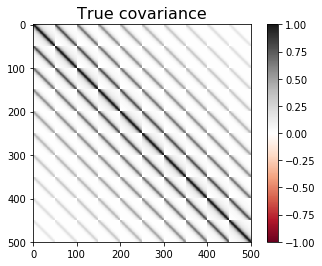

In [60]:
"""
Make a Kernel and compute true covariance matrix
"""

N = 50
num_lags = 10

K_1 = synth_data.gen_gp_kernel(kernel_type="squared_exp", spatial_scale=5., temporal_scale=10.)
K_2 = synth_data.gen_gp_kernel(kernel_type="squared_exp", spatial_scale=10., temporal_scale=5.)
K_3 = synth_data.gen_gp_kernel(kernel_type="exp", spatial_scale=15., temporal_scale=1.)

def K(a,b,c,d):
    return (K_1(a,b,c,d) + K_2(a,b,c,d) +  K_3(a,b,c,d))/3


true_cov = synth_data.gen_gp_cov(num_lags, N, K)
disp_cov(true_cov, "True covariance")

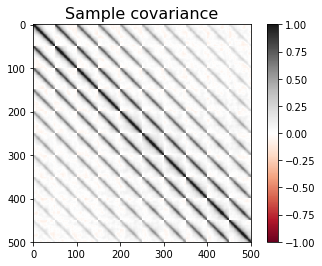

In [64]:
"""
Generate data from the kernel
"""

num_samples = 1000
X_with_lags = np.random.multivariate_normal(mean=np.zeros(true_cov.shape[0]), cov=true_cov, size=num_samples)
X_with_lags -= X_with_lags.mean(axis=0)

"""
Compute sample covariance matrix
"""
    
sample_cov = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)
disp_cov(sample_cov, "Sample covariance")


CV eigvall < 0 -0.02588005564969831
CV eigvall < 0 -0.02748252530872615
CV eigvall < 0 -0.005909250636929915
CV eigvall < 0 -0.006813000874324673
CV eigvall < 0 -0.008611579997884087
CV eigvall < 0 -0.009339738971475916
CV eigvall < 0 -0.015978903160129315
CV eigvall < 0 -0.016154565613922006


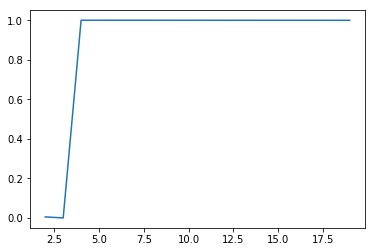

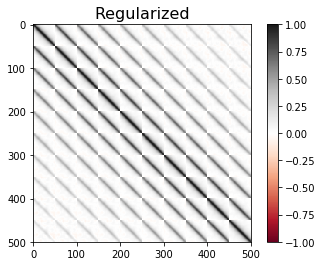

In [65]:
ll, cov_reg = kron_pca.cv_toeplitz(X_with_lags, N, num_lags, num_folds=5, max_r=2*num_lags - 1, small_eigval=1e-6)

ll_avg = ll.mean(axis=0)
ll_avg = ll_avg - ll_avg.min()
ll_avg = ll_avg/np.max(ll_avg)

#plt.yscale("log")
plt.plot(np.arange(1, len(ll_avg))+1, ll_avg[1:])
plt.show()

disp_cov(cov_reg, title="Regularized")

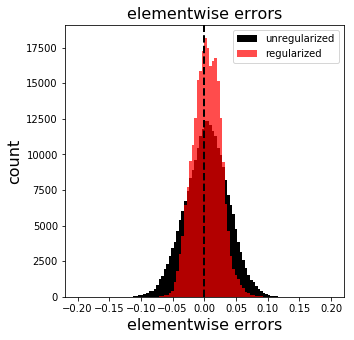

1.546172830687969


In [71]:
"""
Visualize results
"""

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
err_noreg = (sample_cov - true_cov).flatten()
err_reg = (cov_reg - true_cov).flatten()
ax.hist(err_noreg, range=(-0.2, 0.2), bins=100, label="unregularized", color="0.0")
ax.hist(err_reg, range=(-0.2, 0.2), bins=100, label="regularized", color="red", alpha=0.70)
ax.axvline(0, c="black", linestyle="--", linewidth=2)
ax.set_xlabel("elementwise errors", fontsize=16)
ax.set_ylabel("count", fontsize=16)
ax.set_title("elementwise errors", fontsize=16)
ax.legend()
plt.show()

print( np.sqrt(np.mean(err_noreg**2))/np.sqrt(np.mean(err_reg**2)))